In [2]:
# @title
!pip install feature-engine
!pip install holidays keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.7 MB/s eta 0:00:00


In [4]:
# @title
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
df = pd.read_excel("/content/dataset.xlsx")
df

,Unnamed: 0,date,sales
0,0,2013-01-01,13
1,1,2013-01-02,11
2,2,2013-01-03,14
3,3,2013-01-04,13
4,4,2013-01-05,10
...,...,...,...
1821,1821,2017-12-27,14
1822,1822,2017-12-28,19
1823,1823,2017-12-29,15
1824,1824,2017-12-30,27


In [6]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [7]:
date_time = pd.DataFrame(df['date'])

In [8]:
df['date'] = df['date'].astype(str) + ' 00:00:00'

In [9]:
df.head()

,date,sales
0,2013-01-01 00:00:00,13
1,2013-01-02 00:00:00,11
2,2013-01-03 00:00:00,14
3,2013-01-04 00:00:00,13
4,2013-01-05 00:00:00,10


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sales,1826.0,19.971522,6.741022,4.0,15.0,19.0,24.0,50.0


In [11]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

def dateTimeToSignal(df):
    '''
    Converts the DateTime index to timestamp and converts it to signal (sine and cosine) to deal with periodicity.
    Input:
        df: DataFrame with a DateTime index
    Output:
        df: DataFrame with additional columns representing Sin/Cosine signals for timestamp, month, day, week, and year
    '''
    # Ensure the index is a datetime object
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    timestamp_s = df.index.map(datetime.datetime.timestamp)
    day = 24 * 60 * 60
    week = 7 * day
    year = 365.2425 * day

    # Extract month and day components
    df['Month'] = df.index.month
    df['Day_of_month'] = df.index.day

    # Apply cyclical features transformer to month and day columns
    cyclical_transformer = CyclicalFeatures(
        variables=['Month', 'Day_of_month'],  # specify the variable to transform
        drop_original=True  # drop the original variables
    )

    df = cyclical_transformer.fit_transform(df)

    df['Week sin'] = np.sin(2 * np.pi * timestamp_s / week)
    df['Week cos'] = np.cos(2 * np.pi * timestamp_s / week)

    df['Year sin'] = np.sin(2 * np.pi * timestamp_s / year)
    df['Year cos'] = np.cos(2 * np.pi * timestamp_s / year)

    return df



In [ ]:
df = dateTimeToSignal(df)

In [ ]:
df

,sales,Month_sin,Month_cos,Day_of_month_sin,Day_of_month_cos,Week sin,Week cos,Year sin,Year cos
date,,,,,,,,,
2013-01-01,13,5.000000e-01,0.866025,2.012985e-01,0.979530,-9.749279e-01,-0.222521,0.009848,0.999952
2013-01-02,11,5.000000e-01,0.866025,3.943559e-01,0.918958,-7.818315e-01,0.623490,0.027048,0.999634
2013-01-03,14,5.000000e-01,0.866025,5.712682e-01,0.820763,-1.801393e-13,1.000000,0.044240,0.999021
2013-01-04,13,5.000000e-01,0.866025,7.247928e-01,0.688967,7.818315e-01,0.623490,0.061418,0.998112
2013-01-05,10,5.000000e-01,0.866025,8.486443e-01,0.528964,9.749279e-01,-0.222521,0.078579,0.996908
...,...,...,...,...,...,...,...,...,...
2017-12-27,14,-2.449294e-16,1.000000,-7.247928e-01,0.688967,-7.818315e-01,0.623490,-0.079736,0.996816
2017-12-28,19,-2.449294e-16,1.000000,-5.712682e-01,0.820763,5.804087e-13,1.000000,-0.062577,0.998040
2017-12-29,15,-2.449294e-16,1.000000,-3.943559e-01,0.918958,7.818315e-01,0.623490,-0.045400,0.998969


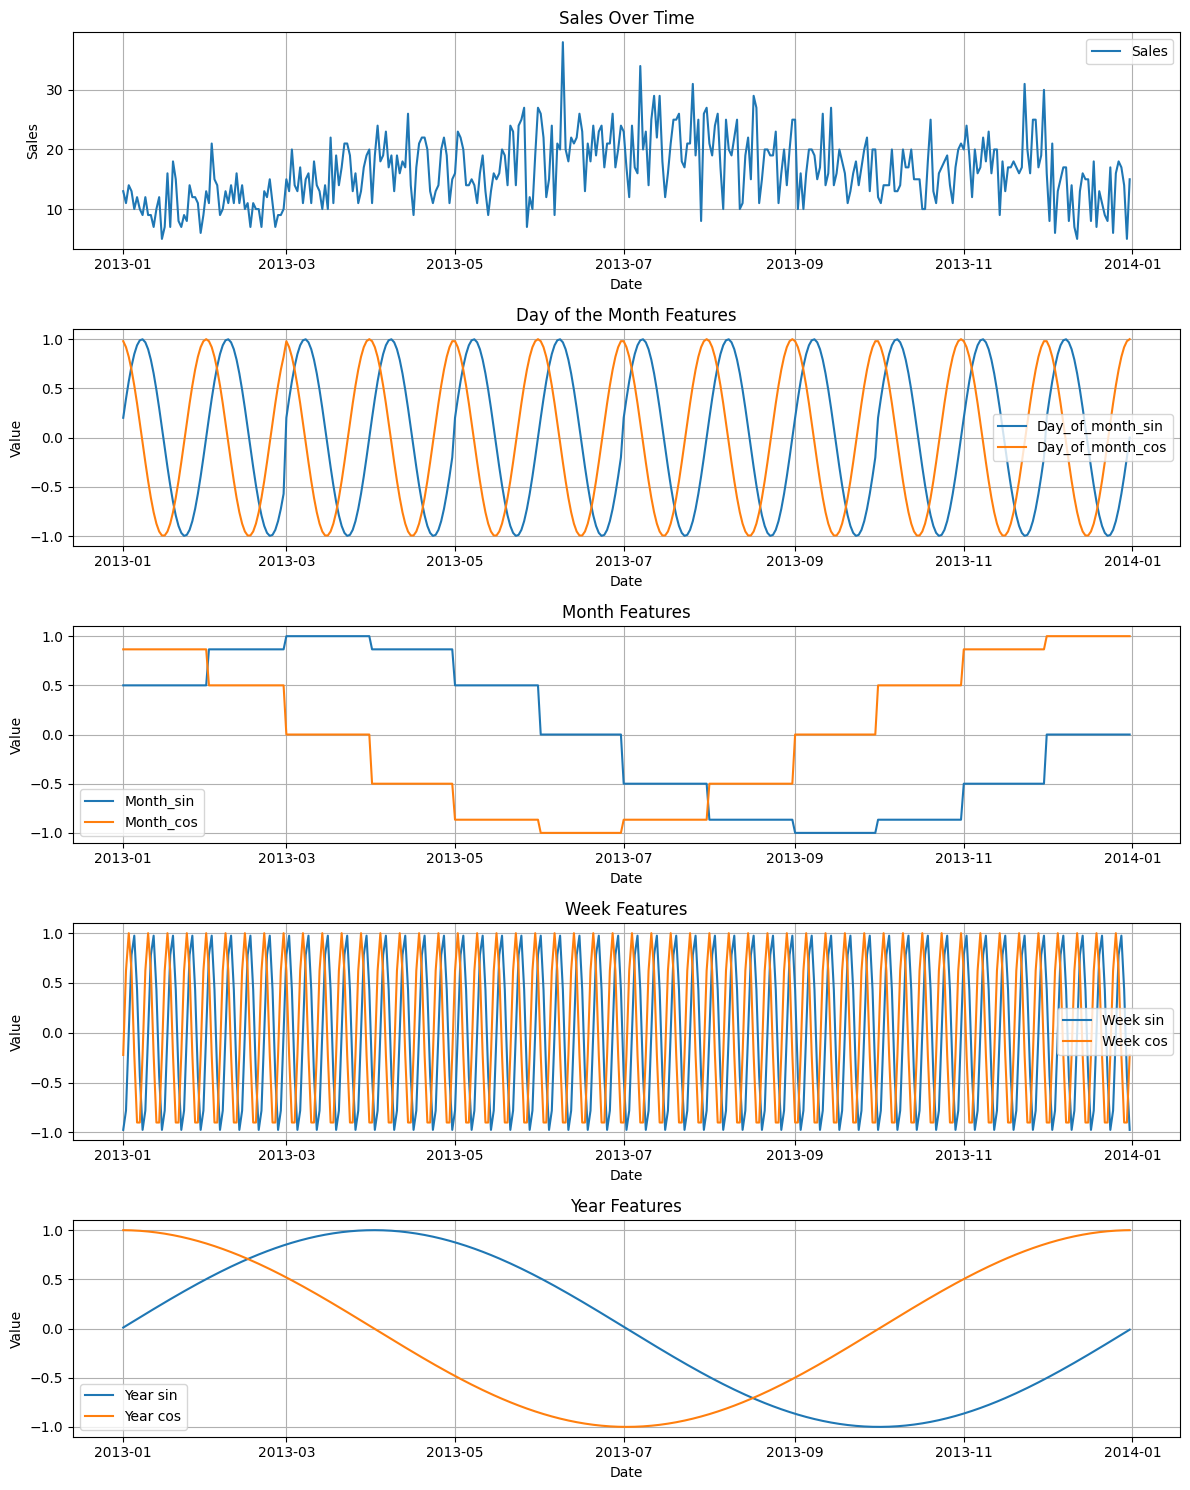

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))

# Select a subset of the data based on the number of rows to display
subset_df = df.iloc[:365,]

# Plot the sales over time
axes[0].plot(subset_df.index, subset_df['sales'], label='Sales')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].set_title('Sales Over Time')
axes[0].legend()
axes[0].grid(True)

# Plot the sine and cosine features for day of the month
axes[1].plot(subset_df.index, subset_df['Day_of_month_sin'], label='Day_of_month_sin')
axes[1].plot(subset_df.index, subset_df['Day_of_month_cos'], label='Day_of_month_cos')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].set_title('Day of the Month Features')
axes[1].legend()
axes[1].grid(True)

# Plot the sine and cosine features for month
axes[2].plot(subset_df.index, subset_df['Month_sin'], label='Month_sin')
axes[2].plot(subset_df.index, subset_df['Month_cos'], label='Month_cos')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Value')
axes[2].set_title('Month Features')
axes[2].legend()
axes[2].grid(True)

# Plot the sine and cosine features for week
axes[3].plot(subset_df.index, subset_df['Week sin'], label='Week sin')
axes[3].plot(subset_df.index, subset_df['Week cos'], label='Week cos')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Value')
axes[3].set_title('Week Features')
axes[3].legend()
axes[3].grid(True)

# Plot the sine and cosine features for year
axes[4].plot(subset_df.index, subset_df['Year sin'], label='Year sin')
axes[4].plot(subset_df.index, subset_df['Year cos'], label='Year cos')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Value')
axes[4].set_title('Year Features')
axes[4].legend()
axes[4].grid(True)

# Adjust subplot spacing
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
import holidays
from datetime import date

bd_holidays = holidays.BD()

def is_holiday(date):
    # Ensure the date is in the correct format (date object)
    if isinstance(date, str):
        date = date.fromisoformat(date)
    return int(date in bd_holidays)

In [ ]:
df['is_holiday'] = df.index.map(is_holiday)
df['is_holiday']

date
2013-01-01    0
2013-01-02    0
2013-01-03    0
2013-01-04    0
2013-01-05    0
             ..
2017-12-27    0
2017-12-28    0
2017-12-29    0
2017-12-30    0
2017-12-31    0
Name: is_holiday, Length: 1826, dtype: int64

Most important frequencies:
Frequency: 0.002738225629791895, Period: 365.2 days
Frequency: 0.1429353778751369, Period: 6.996168582375479 days
Frequency: 0.000547645125958379, Period: 1826.0 days
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days


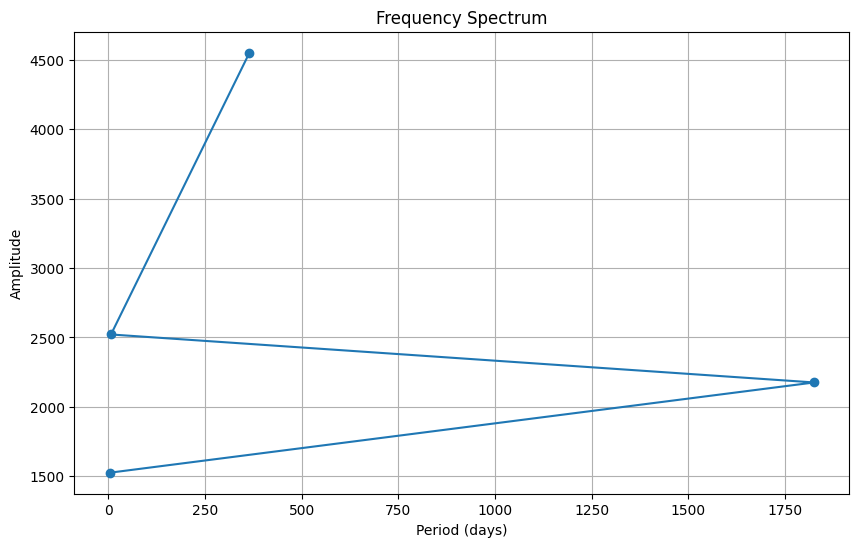

In [ ]:
# Compute the FFT
sales_fft = np.fft.fft(df['sales'])

# Get the frequencies
n = len(df)
frequencies = np.fft.fftfreq(n)
positive_frequencies = frequencies[:n // 2]
amplitudes = np.abs(sales_fft[:n // 2])

# Find the most important frequencies
top_k = 5  # Number of top frequencies to display
top_indices = np.argsort(amplitudes)[::-1][:top_k]

# Plot the frequency spectrum, skipping the first frequency component
plt.figure(figsize=(10, 6))
plt.title("Frequency Spectrum")
plt.plot(1 / positive_frequencies[top_indices[1:]], amplitudes[top_indices[1:]], 'o-')
plt.xlabel("Period (days)")
plt.ylabel("Amplitude")
plt.grid(True)

# Show the most important frequencies, skipping the first one
print("Most important frequencies:")
for idx in top_indices[1:]:
    period = 1 / positive_frequencies[idx]
    print(f"Frequency: {positive_frequencies[idx]}, Period: {period} days")

# Display the plot
plt.show()

Here's an explanation of the output:

Frequency: 0.002738225629791895, Period: 365.2 days:

This frequency component corresponds to a period of approximately one year (365.2 days). It indicates a yearly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-year cycle, which is common in many businesses due to seasonal variations.
Frequency: 0.1429353778751369, Period: 6.996168582375479 days:

This frequency component corresponds to a period of approximately 7 days (6.996 days). It indicates a weekly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-week cycle. This may be related to weekly trends or behaviors in your data.
Frequency: 0.000547645125958379, Period: 1826.0 days:

This frequency component corresponds to a period of approximately 1826 days (about 5 years). It suggests a longer-term cycle or trend in the sales data that repeats every 5 years. This could be associated with macroeconomic or industry-specific factors.
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days:

This frequency component corresponds to a period of approximately 3.5 days. It indicates a short-term cycle or seasonality in the sales data, possibly related to daily fluctuations or events affecting sales on a daily basis.


In summary, the FFT analysis reveals the underlying periodic components in your sales data, helping you understand the different time scales at which patterns and seasonality occur. These insights can be valuable for forecasting, trend analysis, and understanding the dynamics of your sales data.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = 1 # number of target feature

In [ ]:
FEATURES = ['Month_sin', 'Month_cos', 'Day_of_month_sin','Day_of_month_cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos','is_holiday']

In [ ]:
column_indices

{'sales': 0,
 'Month_sin': 1,
 'Month_cos': 2,
 'Day_of_month_sin': 3,
 'Day_of_month_cos': 4,
 'Week sin': 5,
 'Week cos': 6,
 'Year sin': 7,
 'Year cos': 8,
 'is_holiday': 9}

In [ ]:
train_sales = train_df[['sales']]
test_sales = test_df[['sales']]
val_sales = val_df[['sales']]
val_df = val_df.drop(['sales'], axis=1)
train_df = train_df.drop(['sales'], axis=1)
test_df = test_df.drop(['sales'], axis=1)

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df['sales'] = train_sales[['sales']]
val_df['sales'] = val_sales[['sales']]
test_df['sales'] = test_sales[['sales']]

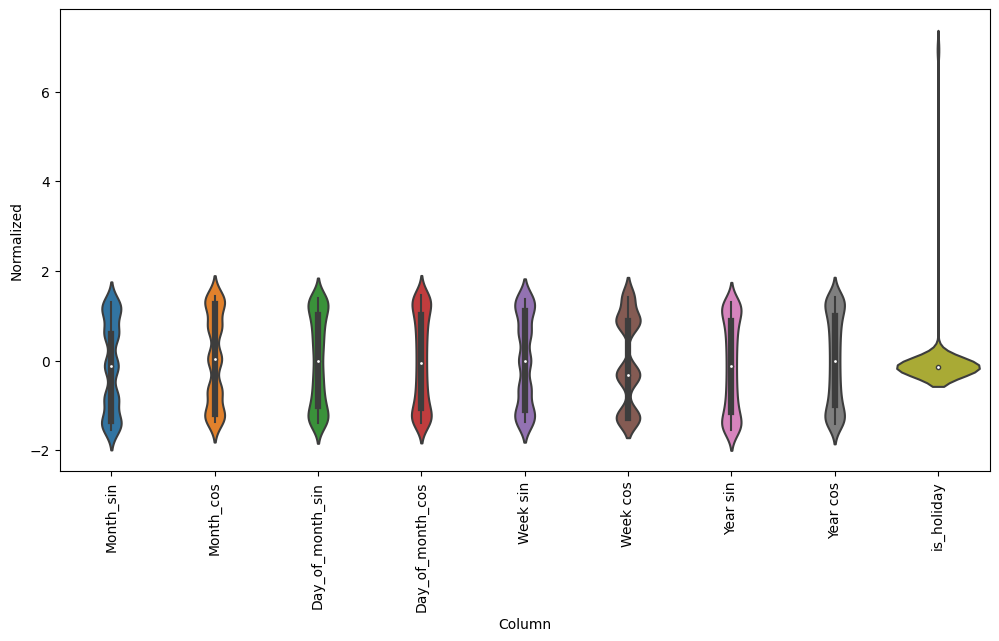

In [ ]:
df2 = df.drop(['sales'], axis=1)
df_std = (df2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['sales'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['sales']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='sales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Period(day)')

WindowGenerator.plot = plot

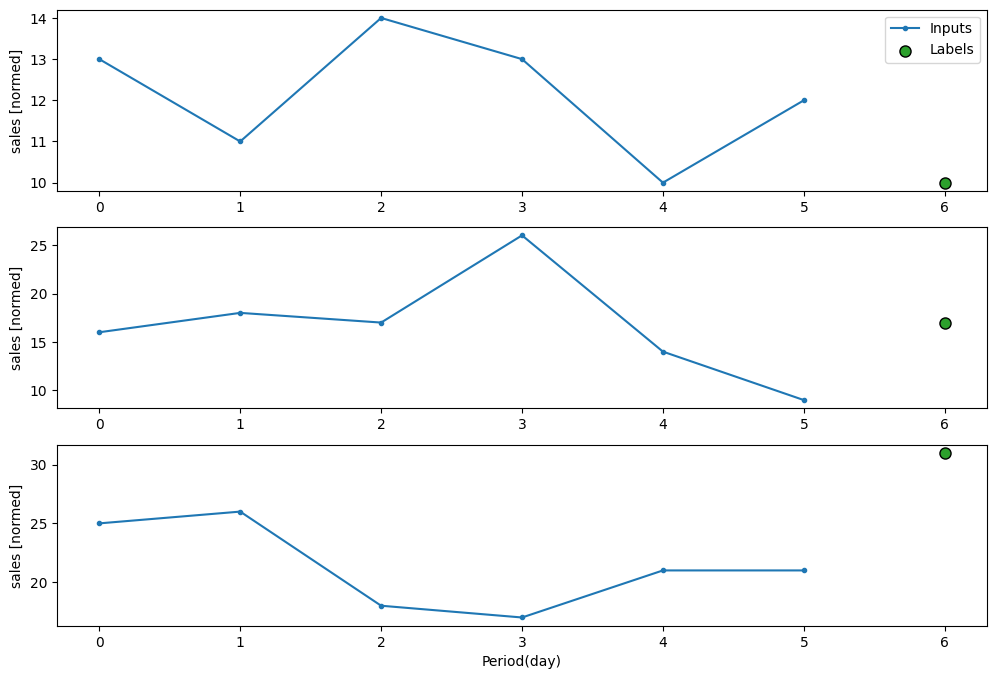

In [ ]:
w2.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
OUT_STEPS = 24
single_step_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['sales'])
single_step_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['sales']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 10)
Labels shape (batch, time, features): (32, 24, 1)


## BiLSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

def bidirectional_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(24, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=512, step=64), activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    bidirectional_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='birectional_lstm_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 8 Complete [00h 00m 09s]
val_mean_squared_error: 29.489728927612305

Best val_mean_squared_error So Far: 29.315229415893555
Total elapsed time: 00h 01m 20s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 24, 512)           546816    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 24, 512)           0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 24)                294936    
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                          

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist1 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 5s - loss: 26.7727 - mean_absolute_error: 4.0447 - root_mean_squared_error: 5.1742 - mean_absolute_percentage_error: 25.1609 - mean_squared_error: 26.7727 - val_loss: 28.3892 - val_mean_absolute_error: 4.2263 - val_root_mean_squared_error: 5.3282 - val_mean_absolute_percentage_error: 21.8923 - val_mean_squared_error: 28.3892 - 5s/epoch - 117ms/step
Epoch 2/50
39/39 - 1s - loss: 24.7439 - mean_absolute_error: 3.9133 - root_mean_squared_error: 4.9743 - mean_absolute_percentage_error: 24.2515 - mean_squared_error: 24.7439 - val_loss: 26.6726 - val_mean_absolute_error: 4.1278 - val_root_mean_squared_error: 5.1646 - val_mean_absolute_percentage_error: 21.8491 - val_mean_squared_error: 26.6726 - 569ms/epoch - 15ms/step
Epoch 3/50
39/39 - 1s - loss: 24.0168 - mean_absolute_error: 3.8697 - root_mean_squared_error: 4.9007 - mean_absolute_percentage_error: 23.8612 - mean_squared_error: 24.0168 - val_loss: 26.0033 - val_mean_absolute_error: 4.0883 - val_root_mean_squared_error:

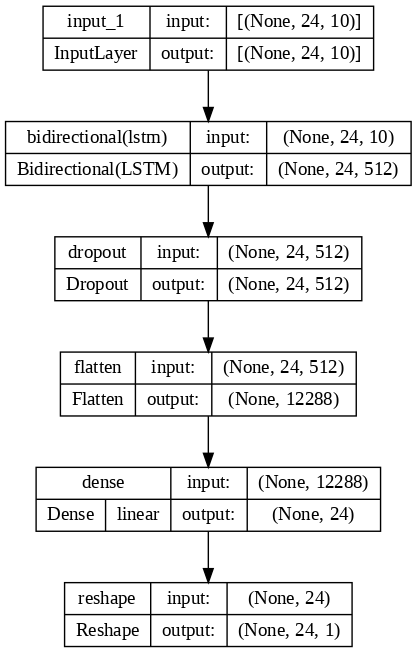

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)
best_model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 6ms/step - loss: 22.2416 - mean_absolute_error: 3.8736 - root_mean_squared_error: 4.7161 - mean_absolute_percentage_error: 19.0756 - mean_squared_error: 22.2416


{'loss': 22.241628646850586,
 'mean_absolute_error': 3.873555898666382,
 'root_mean_squared_error': 4.7161030769348145,
 'mean_absolute_percentage_error': 19.0755558013916,
 'mean_squared_error': 22.24163055419922}

In [ ]:
score

{'loss': 22.24163055419922,
 'mean_absolute_error': 3.8735554218292236,
 'root_mean_squared_error': 4.716103553771973,
 'mean_absolute_percentage_error': 19.0755558013916,
 'mean_squared_error': 22.24163246154785}

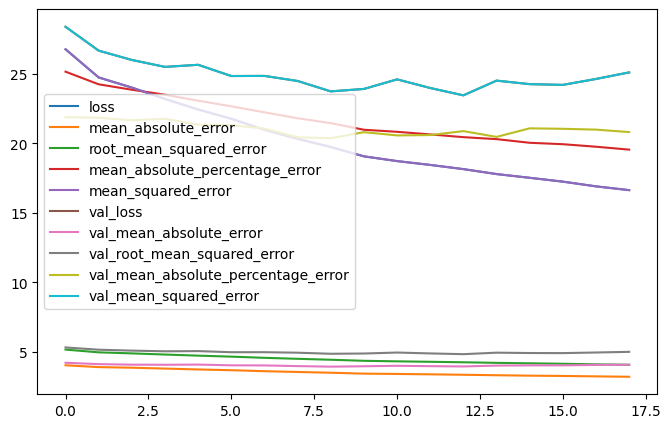

In [ ]:
pd.DataFrame(hist1.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

y_pred_feature = y_pred[:, :, 0]

# Reshape y_pred_feature to match the shape of y_test
y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

# Flatten both y_test and y_pred_feature for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_feature_reshaped.flatten()

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)

from scipy import stats
print(stats.ttest_ind(y_pred_flat, y_test_flat))

TtestResult(statistic=-7.261291347052438, pvalue=4.279601702446669e-13, df=6526.0)


## CNN

In [ ]:
def cnn_model(hp):
  model = tf.keras.Sequential()
  model.add(Input(shape=(24,10)))

  num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
  k_size = hp.Int('kernel_size', min_value=1, max_value=3, step=1)

  model.add(Conv1D(num_filters, k_size, activation='relu'))
  if hp.Choice('pooling_', ['avg', 'max']) == 'max':
    model.add(MaxPooling1D())
  else:
    model.add(AveragePooling1D())

  model.add(Flatten())
  model.add(Dense(hp.Int('units_fully_connected_dense', min_value=16, max_value=512, step=16), activation='relu'))
  model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear'))
  model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
  model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  return model

tuner = kt.tuners.Hyperband(
    cnn_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='cnn_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 150 Complete [00h 00m 07s]
val_mean_squared_error: 26.566875457763672

Best val_mean_squared_error So Far: 24.875288009643555
Total elapsed time: 00h 11m 19s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 480)           14880     
                                                                 
 average_pooling1d (Average  (None, 11, 480)           0         
 Pooling1D)                                                      
                                                                 
 flatten (Flatten)           (None, 5280)              0         
                                                                 
 dense (Dense)               (None, 480)               2534880   
                                                                 
 dense_1 (Dense)             (None, 24)                11544     
                        

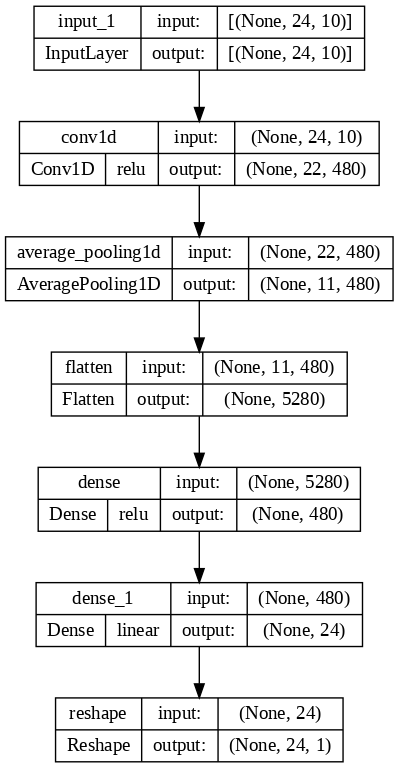

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist2 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 1s - loss: 21.2293 - mean_absolute_error: 3.6428 - root_mean_squared_error: 4.6075 - mean_squared_error: 21.2293 - mean_absolute_percentage_error: 22.3793 - val_loss: 25.2301 - val_mean_absolute_error: 4.0567 - val_root_mean_squared_error: 5.0230 - val_mean_squared_error: 25.2301 - val_mean_absolute_percentage_error: 21.1642 - 1s/epoch - 38ms/step
Epoch 2/50
39/39 - 0s - loss: 20.9030 - mean_absolute_error: 3.6106 - root_mean_squared_error: 4.5720 - mean_squared_error: 20.9030 - mean_absolute_percentage_error: 22.1310 - val_loss: 24.6690 - val_mean_absolute_error: 4.0210 - val_root_mean_squared_error: 4.9668 - val_mean_squared_error: 24.6690 - val_mean_absolute_percentage_error: 21.2771 - 280ms/epoch - 7ms/step
Epoch 3/50
39/39 - 0s - loss: 20.7157 - mean_absolute_error: 3.5929 - root_mean_squared_error: 4.5515 - mean_squared_error: 20.7157 - mean_absolute_percentage_error: 21.9668 - val_loss: 24.2260 - val_mean_absolute_error: 4.0067 - val_root_mean_squared_error: 4

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)
best_model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 4ms/step - loss: 22.3396 - mean_absolute_error: 3.8824 - root_mean_squared_error: 4.7265 - mean_squared_error: 22.3396 - mean_absolute_percentage_error: 19.6894


{'loss': 22.339582443237305,
 'mean_absolute_error': 3.8823795318603516,
 'root_mean_squared_error': 4.726476669311523,
 'mean_squared_error': 22.339582443237305,
 'mean_absolute_percentage_error': 19.689409255981445}

In [ ]:
score

{'loss': 22.339584350585938,
 'mean_absolute_error': 3.8823797702789307,
 'root_mean_squared_error': 4.726476669311523,
 'mean_squared_error': 22.339582443237305,
 'mean_absolute_percentage_error': 19.689411163330078}

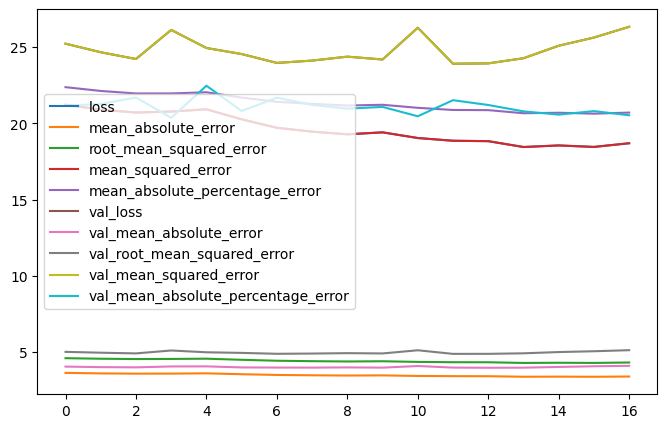

In [ ]:
pd.DataFrame(hist2.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

y_pred_feature = y_pred[:, :, 0]

# Reshape y_pred_feature to match the shape of y_test
y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

# Flatten both y_test and y_pred_feature for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_feature_reshaped.flatten()

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)

from scipy import stats
print(stats.ttest_ind(y_pred_flat, y_test_flat))

TtestResult(statistic=-4.148575576989392, pvalue=3.3879860321458054e-05, df=6526.0)


## RNN

In [ ]:
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional, SimpleRNN

def RNN_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(24, 10)))
    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    #model.add(SimpleRNN(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation="tanh", use_bias=True, return_sequences=True))
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32), activation="tanh", use_bias=True, return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    RNN_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='rnn_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 95 Complete [00h 00m 06s]
val_mean_squared_error: 25.746931076049805

Best val_mean_squared_error So Far: 23.328731536865234
Total elapsed time: 00h 13m 02s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 288)           86112     
                                                                 
 dropout (Dropout)           (None, 24, 288)           0         
                                                                 
 flatten (Flatten)           (None, 6912)              0         
                                                                 
 dense (Dense)               (None, 24)                165912    
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 252024 (984

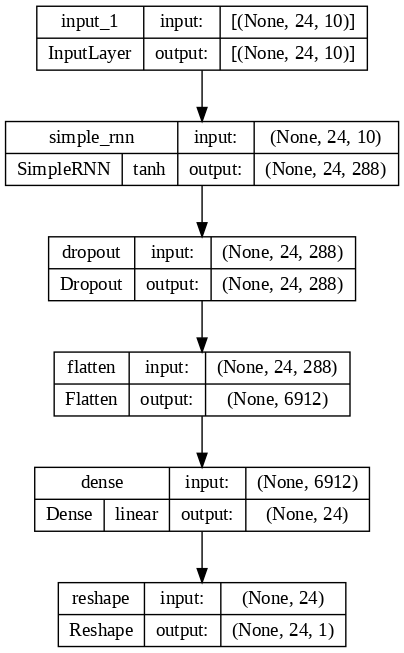

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist3 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 3s - loss: 18.6778 - mean_absolute_error: 3.4117 - root_mean_squared_error: 4.3218 - mean_absolute_percentage_error: 20.8131 - mean_squared_error: 18.6778 - val_loss: 24.6788 - val_mean_absolute_error: 3.9691 - val_root_mean_squared_error: 4.9678 - val_mean_absolute_percentage_error: 20.7381 - val_mean_squared_error: 24.6788 - 3s/epoch - 83ms/step
Epoch 2/50
39/39 - 1s - loss: 17.6479 - mean_absolute_error: 3.3078 - root_mean_squared_error: 4.2009 - mean_absolute_percentage_error: 20.1037 - mean_squared_error: 17.6479 - val_loss: 24.2917 - val_mean_absolute_error: 3.9653 - val_root_mean_squared_error: 4.9287 - val_mean_absolute_percentage_error: 21.0371 - val_mean_squared_error: 24.2917 - 886ms/epoch - 23ms/step
Epoch 3/50
39/39 - 1s - loss: 16.5761 - mean_absolute_error: 3.1999 - root_mean_squared_error: 4.0714 - mean_absolute_percentage_error: 19.3652 - mean_squared_error: 16.5761 - val_loss: 23.9465 - val_mean_absolute_error: 3.9628 - val_root_mean_squared_error: 

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)
best_model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 6ms/step - loss: 24.5908 - mean_absolute_error: 4.1455 - root_mean_squared_error: 4.9589 - mean_absolute_percentage_error: 20.9531 - mean_squared_error: 24.5908


{'loss': 24.59077262878418,
 'mean_absolute_error': 4.145549774169922,
 'root_mean_squared_error': 4.9589080810546875,
 'mean_absolute_percentage_error': 20.95307159423828,
 'mean_squared_error': 24.59077262878418}

In [ ]:
score

{'loss': 24.590770721435547,
 'mean_absolute_error': 4.145549774169922,
 'root_mean_squared_error': 4.9589080810546875,
 'mean_absolute_percentage_error': 20.953075408935547,
 'mean_squared_error': 24.590770721435547}

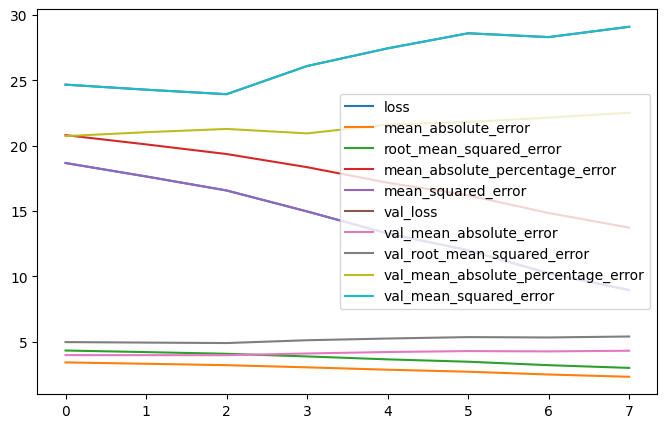

In [ ]:
pd.DataFrame(hist3.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

y_pred_feature = y_pred[:, :, 0]

# Reshape y_pred_feature to match the shape of y_test
y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

# Flatten both y_test and y_pred_feature for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_feature_reshaped.flatten()

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)

from scipy import stats
print(stats.ttest_ind(y_pred_flat, y_test_flat))

TtestResult(statistic=-4.194123746152866, pvalue=2.775550304178712e-05, df=6526.0)


## Stacked LSTM

In [ ]:
def stacked_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(24, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))


    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    stacked_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='stacked_lstm_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist4 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Trial 108 Complete [00h 00m 15s]
val_mean_squared_error: 26.871124267578125

Best val_mean_squared_error So Far: 23.630998611450195
Total elapsed time: 00h 23m 11s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 512)           1071104   
                                                                 
 dropout (Dropout)           (None, 24, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 512)           2099200   
                                                                 
 dropout_1 (Dropout)         (None, 24, 512)           0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)          

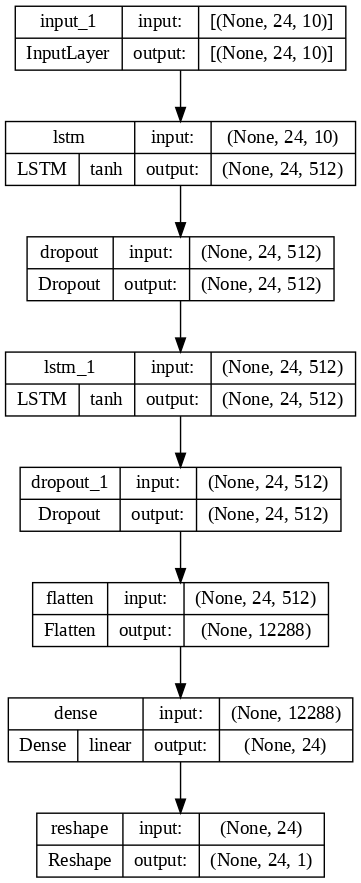

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist4 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 6s - loss: 19.5221 - mean_absolute_error: 3.4921 - root_mean_squared_error: 4.4184 - mean_absolute_percentage_error: 21.3181 - mean_squared_error: 19.5221 - val_loss: 25.0072 - val_mean_absolute_error: 4.0209 - val_root_mean_squared_error: 5.0007 - val_mean_absolute_percentage_error: 20.4771 - val_mean_squared_error: 25.0072 - 6s/epoch - 145ms/step
Epoch 2/50
39/39 - 1s - loss: 18.9082 - mean_absolute_error: 3.4391 - root_mean_squared_error: 4.3484 - mean_absolute_percentage_error: 20.9681 - mean_squared_error: 18.9082 - val_loss: 23.6843 - val_mean_absolute_error: 3.9549 - val_root_mean_squared_error: 4.8667 - val_mean_absolute_percentage_error: 20.9891 - val_mean_squared_error: 23.6843 - 532ms/epoch - 14ms/step
Epoch 3/50
39/39 - 1s - loss: 18.5710 - mean_absolute_error: 3.4116 - root_mean_squared_error: 4.3094 - mean_absolute_percentage_error: 20.7925 - mean_squared_error: 18.5710 - val_loss: 24.1879 - val_mean_absolute_error: 4.0221 - val_root_mean_squared_error:

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)
best_model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 6ms/step - loss: 22.2924 - mean_absolute_error: 3.8723 - root_mean_squared_error: 4.7215 - mean_absolute_percentage_error: 19.4433 - mean_squared_error: 22.2924


{'loss': 22.292438507080078,
 'mean_absolute_error': 3.872344732284546,
 'root_mean_squared_error': 4.721486568450928,
 'mean_absolute_percentage_error': 19.443262100219727,
 'mean_squared_error': 22.292436599731445}

In [ ]:
score

{'loss': 22.292438507080078,
 'mean_absolute_error': 3.872344732284546,
 'root_mean_squared_error': 4.721487045288086,
 'mean_absolute_percentage_error': 19.443262100219727,
 'mean_squared_error': 22.29244041442871}

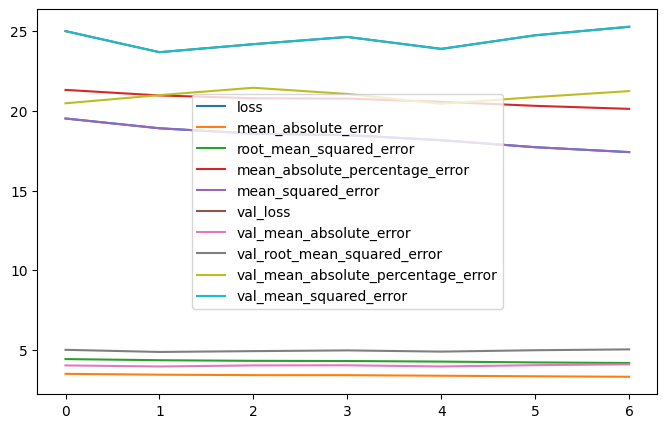

In [ ]:
pd.DataFrame(hist4.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

y_pred_feature = y_pred[:, :, 0]

# Reshape y_pred_feature to match the shape of y_test
y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

# Flatten both y_test and y_pred_feature for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_feature_reshaped.flatten()

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)

from scipy import stats
print(stats.ttest_ind(y_pred_flat, y_test_flat))

TtestResult(statistic=-5.281935321000128, pvalue=1.319612343677666e-07, df=6526.0)


## Vanilla LSTM

In [ ]:
def vanila_LSTM(hp):
    inputs = Input(shape=(24, 10))

    X = LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid')(inputs)
    outputs = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros())(X)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="vanilla_lstm_model")

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    vanila_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='vanilla',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Reloading Tuner from stacked_lstm_exp/demand forecasting/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Model: "vanilla_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 10)]          0         
                                                                 
 lstm (LSTM)                 (None, 512)               1071104   
                                                                 
 dense (Dense)               (None, 24)                12312     
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                      

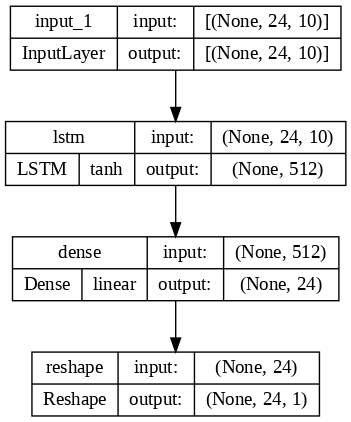

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist5 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 3s - loss: 122.6954 - mean_absolute_error: 8.5557 - root_mean_squared_error: 11.0768 - mean_absolute_percentage_error: 49.0436 - mean_squared_error: 122.6954 - val_loss: 49.3404 - val_mean_absolute_error: 5.5149 - val_root_mean_squared_error: 7.0243 - val_mean_absolute_percentage_error: 26.6169 - val_mean_squared_error: 49.3404 - 3s/epoch - 78ms/step
Epoch 2/50
39/39 - 0s - loss: 41.2556 - mean_absolute_error: 5.1083 - root_mean_squared_error: 6.4231 - mean_absolute_percentage_error: 32.6461 - mean_squared_error: 41.2556 - val_loss: 42.6150 - val_mean_absolute_error: 5.1862 - val_root_mean_squared_error: 6.5280 - val_mean_absolute_percentage_error: 26.8830 - val_mean_squared_error: 42.6150 - 421ms/epoch - 11ms/step
Epoch 3/50
39/39 - 0s - loss: 40.1149 - mean_absolute_error: 5.0314 - root_mean_squared_error: 6.3336 - mean_absolute_percentage_error: 32.1655 - mean_squared_error: 40.1149 - val_loss: 43.3438 - val_mean_absolute_error: 5.2197 - val_root_mean_squared_erro

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)
best_model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 6ms/step - loss: 48.0951 - mean_absolute_error: 5.5638 - root_mean_squared_error: 6.9351 - mean_absolute_percentage_error: 26.0264 - mean_squared_error: 48.0951


{'loss': 48.09513473510742,
 'mean_absolute_error': 5.563836097717285,
 'root_mean_squared_error': 6.935064792633057,
 'mean_absolute_percentage_error': 26.026351928710938,
 'mean_squared_error': 48.09512710571289}

In [ ]:
score

{'loss': 48.09513473510742,
 'mean_absolute_error': 5.563836097717285,
 'root_mean_squared_error': 6.935065269470215,
 'mean_absolute_percentage_error': 26.026351928710938,
 'mean_squared_error': 48.09513473510742}

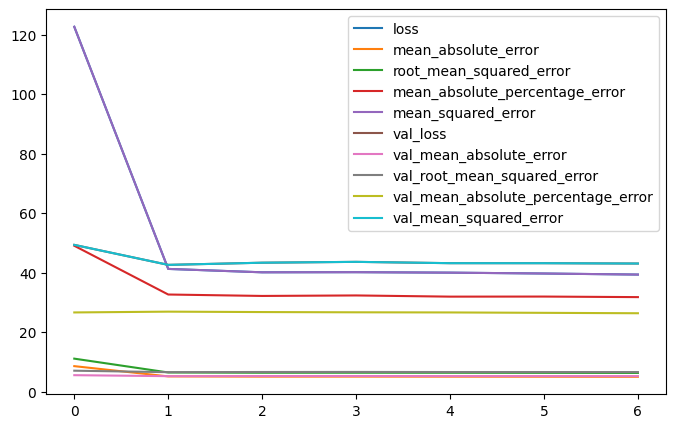

In [ ]:
pd.DataFrame(hist5.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

y_pred_feature = y_pred[:, :, 0]

# Reshape y_pred_feature to match the shape of y_test
y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

# Flatten both y_test and y_pred_feature for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_feature_reshaped.flatten()

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)

from scipy import stats
print(stats.ttest_ind(y_pred_flat, y_test_flat))

TtestResult(statistic=-27.587075147316078, pvalue=1.486857607715687e-158, df=6526.0)


## MLP

In [ ]:
def mlp_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(24, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    #  hp_activation=hp.Choice('activation' + str(i), ['relu', 'tanh', 'relu'])
    hp_activation=hp.Choice('activation', ['relu', 'tanh', 'relu'])
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation=hp_activation))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.0)))

    model.add(Dense(num_features, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

    return model


tuner = kt.tuners.Hyperband(
    mlp_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='mlp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Reloading Tuner from stacked_lstm_exp/demand forecasting/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 512)           5632      
                                                                 
 dropout (Dropout)           (None, 24, 512)           0         
                                                                 
 dense_1 (Dense)             (None, 24, 1)             513       
                                                                 
Total params: 6145 (24.00 KB)
Trainable params: 6145 (24.00 KB)
Non-trainable params: 0 (0.00 By

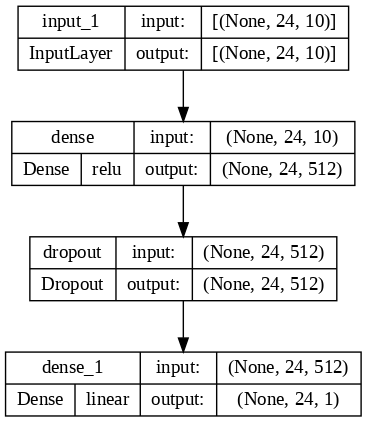

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist6 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 2s - loss: 109.5751 - mean_absolute_error: 8.1053 - mean_squared_error: 109.5751 - root_mean_squared_error: 10.4678 - mean_absolute_percentage_error: 45.7029 - val_loss: 47.5015 - val_mean_absolute_error: 5.5336 - val_mean_squared_error: 47.5015 - val_root_mean_squared_error: 6.8921 - val_mean_absolute_percentage_error: 27.6661 - 2s/epoch - 64ms/step
Epoch 2/50
39/39 - 1s - loss: 39.9386 - mean_absolute_error: 5.0420 - mean_squared_error: 39.9386 - root_mean_squared_error: 6.3197 - mean_absolute_percentage_error: 29.8467 - val_loss: 40.5042 - val_mean_absolute_error: 5.1427 - val_mean_squared_error: 40.5042 - val_root_mean_squared_error: 6.3643 - val_mean_absolute_percentage_error: 26.8100 - 506ms/epoch - 13ms/step
Epoch 3/50
39/39 - 0s - loss: 34.5257 - mean_absolute_error: 4.6767 - mean_squared_error: 34.5257 - root_mean_squared_error: 5.8759 - mean_absolute_percentage_error: 27.8252 - val_loss: 36.6894 - val_mean_absolute_error: 4.8587 - val_mean_squared_error: 36

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)
best_model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 5ms/step - loss: 32.0749 - mean_absolute_error: 4.5589 - mean_squared_error: 32.0749 - root_mean_squared_error: 5.6635 - mean_absolute_percentage_error: 21.5151


{'loss': 32.074920654296875,
 'mean_absolute_error': 4.558850288391113,
 'mean_squared_error': 32.074920654296875,
 'root_mean_squared_error': 5.6634721755981445,
 'mean_absolute_percentage_error': 21.51509666442871}

In [ ]:
score

{'loss': 32.074920654296875,
 'mean_absolute_error': 4.558850288391113,
 'mean_squared_error': 32.07491683959961,
 'root_mean_squared_error': 5.6634721755981445,
 'mean_absolute_percentage_error': 21.51509666442871}

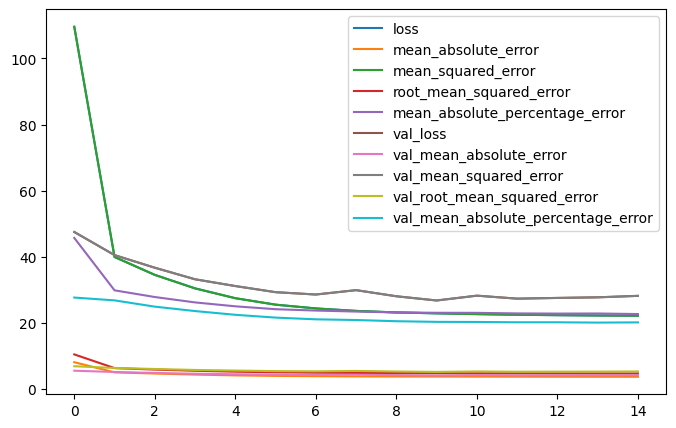

In [ ]:
pd.DataFrame(hist6.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

y_pred_feature = y_pred[:, :, 0]

# Reshape y_pred_feature to match the shape of y_test
y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

# Flatten both y_test and y_pred_feature for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_feature_reshaped.flatten()

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)

from scipy import stats
print(stats.ttest_ind(y_pred_flat, y_test_flat))

TtestResult(statistic=-18.183427030286754, pvalue=4.114830159360442e-72, df=6526.0)


## CNN-LSTM-GRU (Proposed)

In [ ]:
# @title
'''
def hybrid_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(24, 10)))

    #num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
    #k_size = hp.Int('kernel_size', min_value=1, max_value=3, step=1)

    model.add(Conv1D(num_filters=320, k_size=1, activation='relu'))
    model.add(MaxPooling1D())

    model.add(Dense(480, activation='relu'))

    model.add(Bidirectional(LSTM(320, return_sequences=True)))
    #tf.keras.layers.Attention()([lstm, lstm])
    model.add(LSTM(320, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(320, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear'))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

    return model



tuner = kt.tuners.Hyperband(
    hybrid_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='hybrid_model',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()
'''

Trial 132 Complete [00h 00m 17s]
val_mean_squared_error: 40.68994140625

Best val_mean_squared_error So Far: 26.096084594726562
Total elapsed time: 00h 36m 16s

Search: Running Trial #133

Value             |Best Value So Far |Hyperparameter
112               |320               |filters_cnn_layer
3                 |1                 |kernel_size
avg               |max               |pooling_
512               |320               |units
4                 |10                |tuner/epochs
2                 |0                 |tuner/initial_epoch
2                 |0                 |tuner/bracket
1                 |0                 |tuner/round
0126              |None              |tuner/trial_id



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate, GRU
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

# Create a Sequential model
model = Sequential()

# Add the input layer
inputs = Input(shape=(24, 10), name='input_layer')

out1 = Conv1D(320, 1, activation='relu')(inputs)
out1 = MaxPooling1D()(out1)
out1 = Dense(480, activation='relu')(out1)

out1 = Bidirectional(LSTM(320, return_sequences=True))(out1)
out1 = Bidirectional(GRU(320*3, return_sequences=True))(out1)

out1 = Flatten()(out1)

out1 = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear')(out1)
output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(out1)
model = tf.keras.models.Model(inputs=[inputs], outputs=output)
# Compile the model
learning_rate = 1e-3  # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()],
    optimizer=optimizer
)

best_model = model
best_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 24, 10)]          0         
                                                                 
 conv1d_22 (Conv1D)          (None, 24, 320)           3520      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 12, 320)           0         
 ng1D)                                                           
                                                                 
 dense_7 (Dense)             (None, 12, 480)           154080    
                                                                 
 bidirectional_6 (Bidirecti  (None, 12, 640)           2050560   
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 12, 1920)          9227

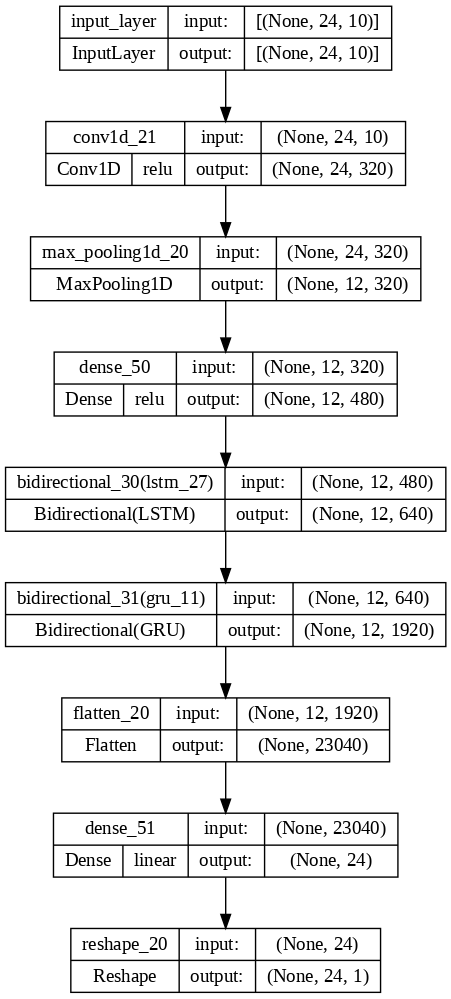

In [ ]:
plot_model(best_model, to_file = 'proposed_demand_forecasting_model.png', show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
# @title
# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)

class ReduceLRBacktrack(tf.keras.callbacks.ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    # print("\n Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

model_path = 'model.h5'

lr_reducer = ReduceLRBacktrack(
    best_path = model_path,
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-10,
    mode='min'
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, save_best_only=True, monitor='val_loss', mode='min')

hist8 = model.fit(
    single_step_window.train,
    batch_size=32,
    epochs = 50,
    #verbose=2,
    callbacks=[checkpoint, lr_reducer, early_stop],
    #callbacks=[lr_reducer],
    shuffle=False,
    validation_data=single_step_window.val,
)

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 87.6705 - mean_absolute_error: 7.1147 - root_mean_squared_error: 9.3633 - mean_absolute_percentage_error: 42.0403 - mean_squared_error: 87.6706

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 15s 79ms/step - loss: 87.6705 - mean_absolute_error: 7.1147 - root_mean_squared_error: 9.3633 - mean_absolute_percentage_error: 42.0403 - mean_squared_error: 87.6706 - val_loss: 39.8390 - val_mean_absolute_error: 5.0585 - val_root_mean_squared_error: 6.3118 - val_mean_absolute_percentage_error: 27.3623 - val_mean_squared_error: 39.8391 - lr: 0.0010
Epoch 2/50
39/39 [==============================] - 1s 37ms/step - loss: 34.7600 - mean_absolute_error: 4.6311 - root_mean_squared_error: 5.8958 - mean_absolute_percentage_error: 29.1440 - mean_squared_error: 34.7600 - val_loss: 33.2325 - val_mean_absolute_error: 4.5538 - val_root_mean_squared_error: 5.7648 - val_mean_absolute_percentage_error: 22.9550 - val_mean_squared_error: 33.2325 - lr: 0.0010
Epoch 3/50
39/39 [==============================] - 1s 34ms/step - loss: 29.4906 - mean_absolute_error: 4.2440 - root_mean_squared_error: 5.4305 - mean_absolute_percentage_error: 26.4182 - mean_squared_erro

In [ ]:
model.evaluate(single_step_window.val, return_dict=True)
model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 24ms/step - loss: 21.7770 - mean_absolute_error: 3.8270 - root_mean_squared_error: 4.6666 - mean_absolute_percentage_error: 18.8820 - mean_squared_error: 21.7770


{'loss': 21.77701759338379,
 'mean_absolute_error': 3.8270461559295654,
 'root_mean_squared_error': 4.6665849685668945,
 'mean_absolute_percentage_error': 18.88198471069336,
 'mean_squared_error': 21.77701759338379}

In [ ]:
score = model.evaluate(single_step_window.test, return_dict=True)
y_pred = model.predict(single_step_window.test)

5/5 [==============================] - 2s 11ms/step


In [ ]:
y_pred

array([[[29.26435 ],
        [18.835503],
        [22.062035],
        ...,
        [27.434505],
        [17.135296],
        [19.944305]],

       [[25.121271],
        [26.042072],
        [16.783655],
        ...,
        [24.65013 ],
        [25.480827],
        [15.854492]],

       [[23.811779],
        [26.542896],
        [28.963799],
        ...,
        [22.14483 ],
        [25.43721 ],
        [26.972836]],

       ...,

       [[20.6277  ],
        [19.56591 ],
        [22.74858 ],
        ...,
        [14.524587],
        [13.736445],
        [17.467968]],

       [[16.729578],
        [20.628242],
        [20.294851],
        ...,
        [14.541188],
        [18.57267 ],
        [18.437416]],

       [[25.531305],
        [29.758396],
        [29.33343 ],
        ...,
        [25.554745],
        [28.049646],
        [28.241295]]], dtype=float32)

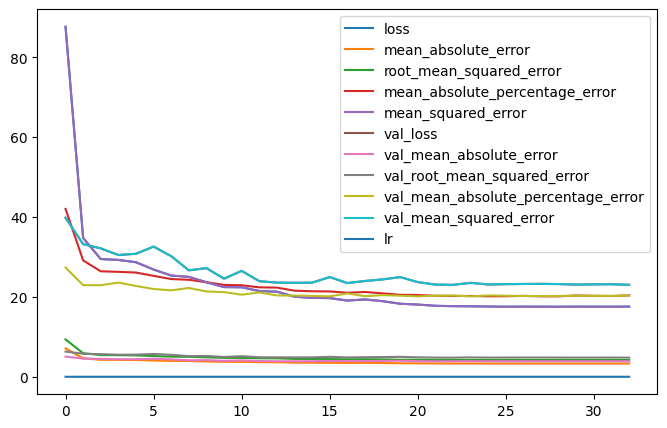

In [ ]:
pd.DataFrame(hist8.history).plot(figsize=(8,5))
plt.show()

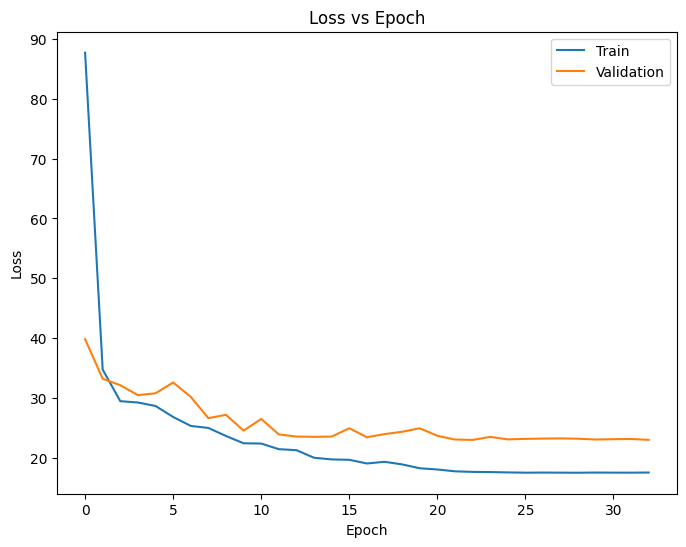

In [ ]:
# "Loss"
plt.plot(hist8.history['loss'])
plt.plot(hist8.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("cnn_bilstm_loss.png", dpi=300)
plt.show()

TtestResult(statistic=-7.667154340277097, pvalue=2.0148148394287095e-14, df=6526.0)
Evaluation for Feature 1:
Mean Squared Error: 54.50382995605469
Mean Absolute Error: 5.924794673919678


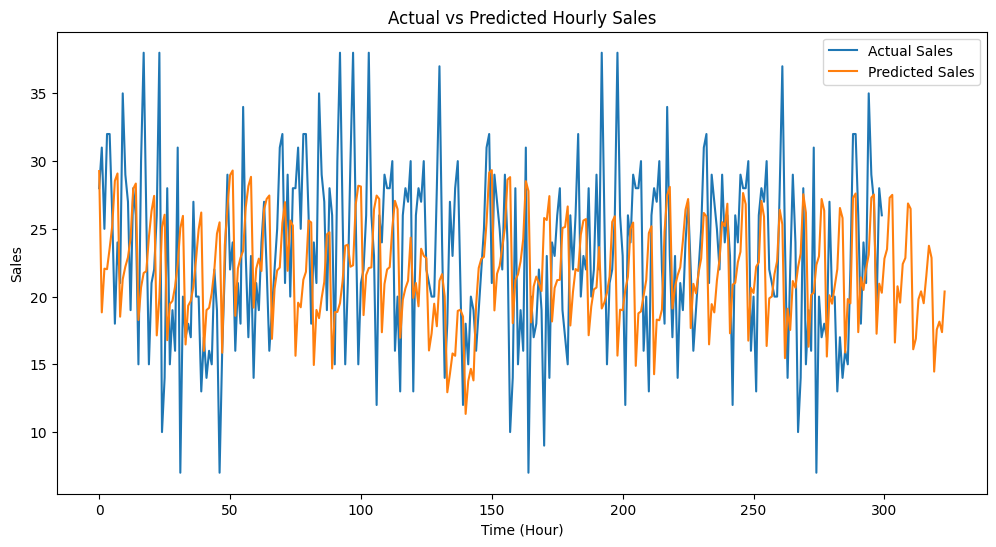

In [ ]:
# Extract the actual values from the test dataset
actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
actual_values = np.array(actual_values)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_plot_feature(y_test, y_pred, feature_index):
    # Extract the specified feature from y_pred
    y_pred_feature = y_pred[:, :, feature_index]

    # Reshape y_pred_feature to match the shape of y_test
    y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

    # Flatten both y_test and y_pred_feature for evaluation
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred_feature_reshaped.flatten()

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)

    from scipy import stats
    print(stats.ttest_ind(y_pred_flat, y_test_flat))

    print(f'Evaluation for Feature {feature_index + 1}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    # Plotting actual vs predicted values
    plt.figure(figsize=(12, 6))

    # Plotting actual values
    plt.plot(y_test_flat[:300], label='Actual Sales')

    # Plotting predicted values
    plt.plot(y_pred_flat[:324], label=f'Predicted Sales')

    plt.title(f'Actual vs Predicted Hourly Sales')
    plt.xlabel('Time (Hour)')
    plt.ylabel(f'Sales')
    plt.legend()
    plt.show()

# Assuming y_test has shape (136, 24, 1) and y_pred has shape (136, 24, 10)

feature_index_to_evaluate = 0  # Adjust the feature index you want to evaluate
evaluate_and_plot_feature(actual_values, y_pred, feature_index_to_evaluate)


## CNN-LSTM-Parallel

In [ ]:
# @title
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential


# Create a Sequential model
model = Sequential()

# Add the input layer
inputs = Input(shape=(24, 10), name='input_layer')  # Adjusted input shape

#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')))

# first input model
# Convolutional Layers
out1 = tf.keras.layers.Conv1D(filters=512, kernel_size=3, strides=1)(inputs) #16
out1 = tf.keras.layers.BatchNormalization()(out1)
for _ in range(5):
    out = tf.keras.layers.Conv1D(filters=128, kernel_size=4, strides=1, padding='same')(out1) #32
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Activation("relu")(out)
    out = tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, padding='same')(out) #16
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Concatenate()([out, out1])
    out = tf.keras.layers.Activation("relu")(out)
    out1 = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(out)

#out1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu'))(out1) # 60
cnn1 = tf.keras.layers.Flatten()(out1)
cnn1 = tf.keras.layers.Dense(480, activation="relu")(cnn1)
#cnn1 = tf.keras.layers.Dense(OUT_STEPS*num_features, activation="relu")(cnn1) #60

# second input model
x0 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(inputs)
x = tf.keras.layers.Concatenate(axis=2)([inputs, x0])
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Concatenate(axis=2)([x0, x1])
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
l5 = tf.keras.layers.Concatenate(axis=2)([x0, x1, x2])

lstm1 = tf.keras.layers.Dense(512, activation="relu")(l5) #128
lstm1 = tf.keras.layers.Dropout(0.2)(lstm1)  # Dropout added after LSTM
lstm1 = tf.keras.layers.Dense(1)(lstm1) ## 1
lstm1 = tf.keras.layers.Flatten()(lstm1)

# Merge input models
merge = Concatenate()([cnn1, lstm1])
merge = tf.keras.layers.Dropout(0.2)(merge)
#dense = Dense(128, activation="relu")(merge) #128
output = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros())(merge)
output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(output)

model = tf.keras.models.Model(inputs=[inputs], outputs=output)


# Compile the model
learning_rate = 1e-4  # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#acc = tf.keras.metrics.RootMeanSquaredError()

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()],
    optimizer=optimizer
)

# Build the model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 24, 10)]             0         []                            
                                                                                                  
 conv1d_11 (Conv1D)          (None, 22, 512)              15872     ['input_layer[0][0]']         
                                                                                                  
 batch_normalization_11 (Ba  (None, 22, 512)              2048      ['conv1d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_12 (Conv1D)          (None, 22, 128)              262272    ['batch_normalization_11[0

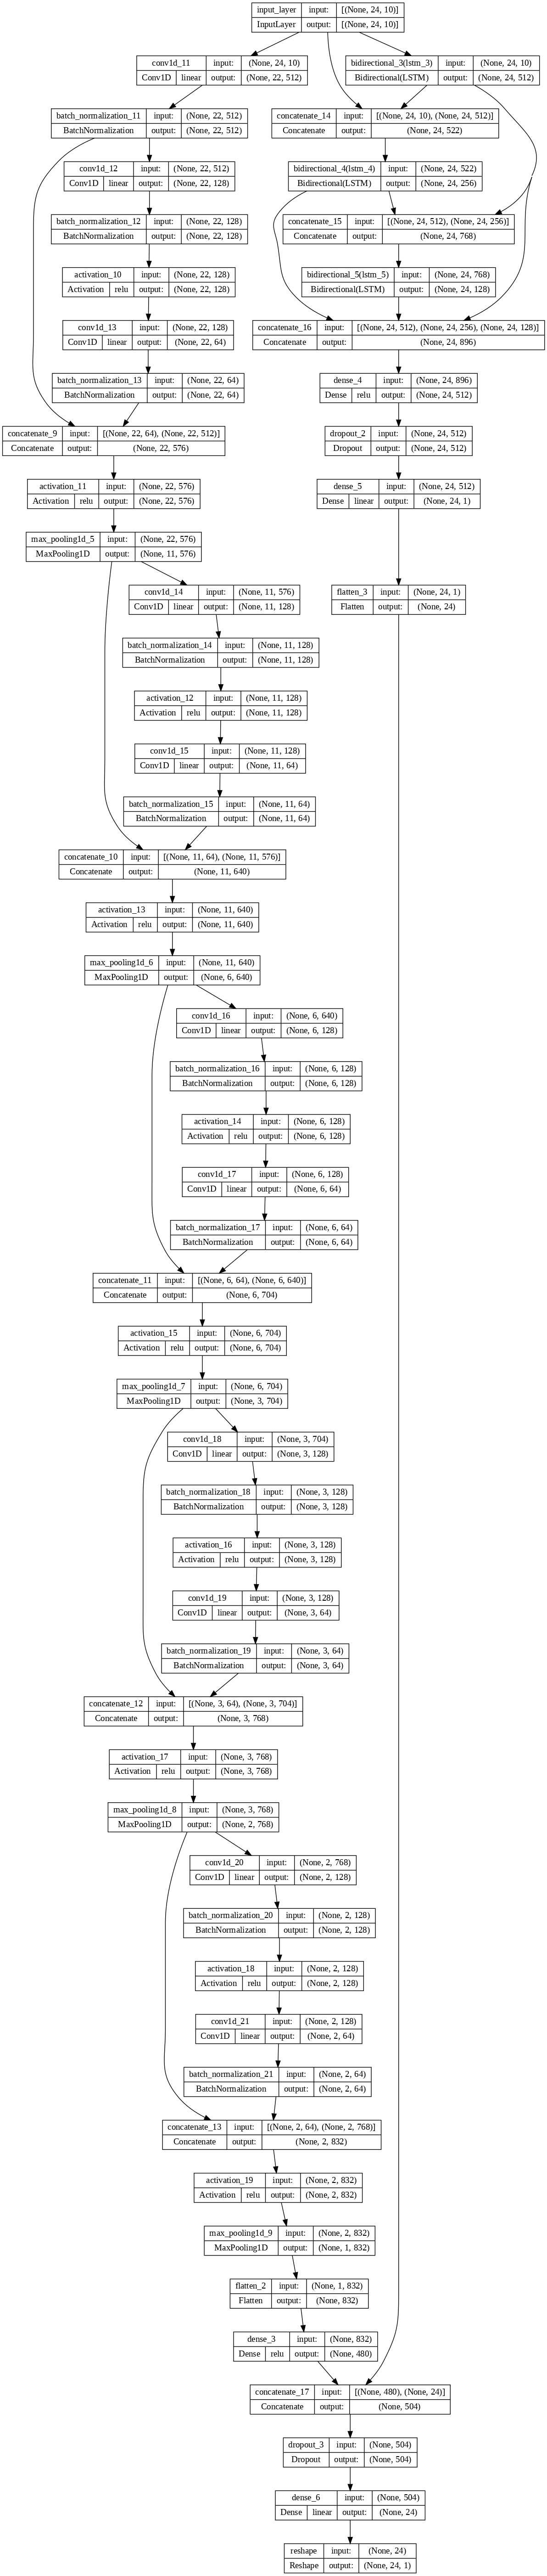

In [ ]:
# @title
#model = best_model
tf.keras.utils.plot_model(model, to_file = 'timeseries_model.png', show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
# @title
# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)

class ReduceLRBacktrack(tf.keras.callbacks.ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    # print("\n Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

model_path = 'model.h5'

lr_reducer = ReduceLRBacktrack(
    best_path = model_path,
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-10,
    mode='min'
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, save_best_only=True, monitor='val_loss', mode='min')

hist7 = model.fit(
    single_step_window.train,
    batch_size=32,
    epochs = 50,
    #verbose=2,
    callbacks=[checkpoint, early_stop],
    #callbacks=[lr_reducer],
    shuffle=False,
    validation_data=single_step_window.val,
)

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 281.8813 - mean_absolute_error: 15.2138 - root_mean_squared_error: 16.7893 - mean_absolute_percentage_error: 77.8382 - mean_squared_error: 281.8813

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 22s 132ms/step - loss: 281.8813 - mean_absolute_error: 15.2138 - root_mean_squared_error: 16.7893 - mean_absolute_percentage_error: 77.8382 - mean_squared_error: 281.8813 - val_loss: 161.3107 - val_mean_absolute_error: 11.2233 - val_root_mean_squared_error: 12.7008 - val_mean_absolute_percentage_error: 49.4557 - val_mean_squared_error: 161.3107
Epoch 2/50
39/39 [==============================] - 2s 45ms/step - loss: 34.7248 - mean_absolute_error: 4.6434 - root_mean_squared_error: 5.8928 - mean_absolute_percentage_error: 28.7107 - mean_squared_error: 34.7248 - val_loss: 76.6788 - val_mean_absolute_error: 7.1794 - val_root_mean_squared_error: 8.7566 - val_mean_absolute_percentage_error: 31.2055 - val_mean_squared_error: 76.6788
Epoch 3/50
39/39 [==============================] - 2s 43ms/step - loss: 29.0616 - mean_absolute_error: 4.2362 - root_mean_squared_error: 5.3909 - mean_absolute_percentage_error: 26.4677 - mean_squared_error: 29.0616 - val_

In [ ]:
model.evaluate(single_step_window.val, return_dict=True)
model.evaluate(single_step_window.test, return_dict=True)

5/5 [==============================] - 0s 12ms/step - loss: 36.7888 - mean_absolute_error: 4.8166 - root_mean_squared_error: 6.0654 - mean_absolute_percentage_error: 23.7109 - mean_squared_error: 36.7888


{'loss': 36.78878402709961,
 'mean_absolute_error': 4.816613674163818,
 'root_mean_squared_error': 6.065375804901123,
 'mean_absolute_percentage_error': 23.71090316772461,
 'mean_squared_error': 36.78878402709961}

In [ ]:
score = model.evaluate(single_step_window.test, return_dict=True)
y_pred = model.predict(single_step_window.test)

5/5 [==============================] - 2s 14ms/step


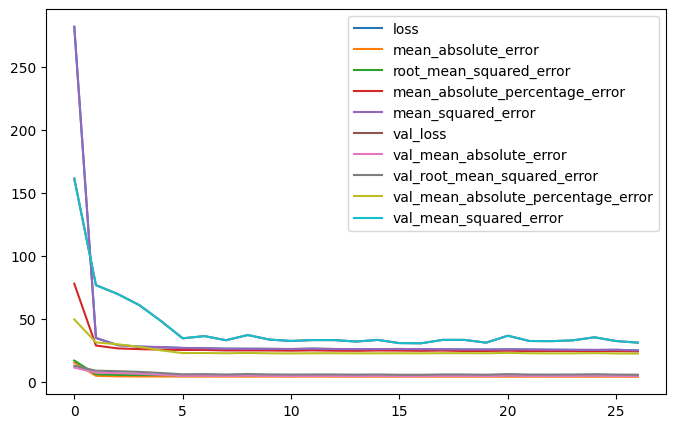

In [ ]:
pd.DataFrame(hist7.history).plot(figsize=(8,5))
plt.show()

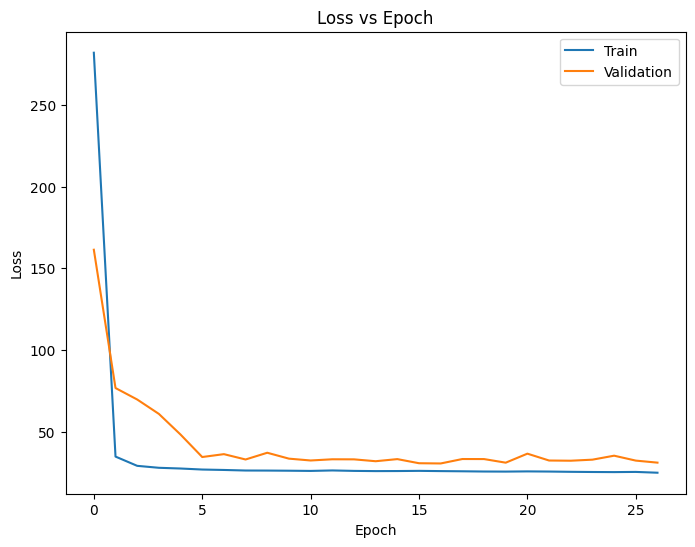

In [ ]:
# "Loss"
plt.plot(hist7.history['loss'])
plt.plot(hist7.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("cnn_bilstm_loss.png", dpi=300)
plt.show()

TtestResult(statistic=-13.360405503653572, pvalue=3.4618855558970485e-40, df=6526.0)
Evaluation for Feature 1:
Mean Squared Error: 48.34086990356445
Mean Absolute Error: 5.588934421539307


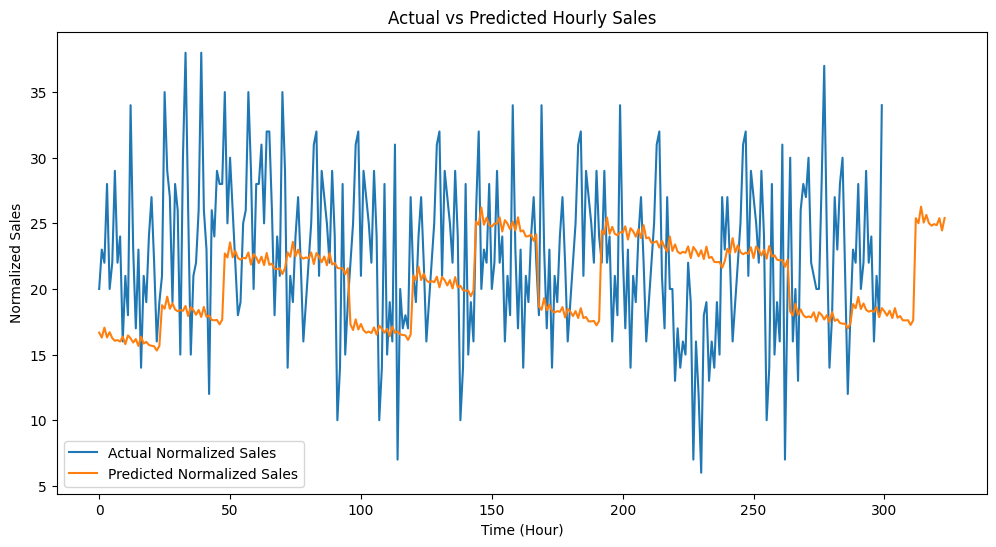

In [ ]:
# Extract the actual values from the test dataset
actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
actual_values = np.array(actual_values)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_plot_feature(y_test, y_pred, feature_index):
    # Extract the specified feature from y_pred
    y_pred_feature = y_pred[:, :, feature_index]

    # Reshape y_pred_feature to match the shape of y_test
    y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

    # Flatten both y_test and y_pred_feature for evaluation
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred_feature_reshaped.flatten()

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)

    from scipy import stats
    print(stats.ttest_ind(y_pred_flat, y_test_flat))

    print(f'Evaluation for Feature {feature_index + 1}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    # Plotting actual vs predicted values
    plt.figure(figsize=(12, 6))

    # Plotting actual values
    plt.plot(y_test_flat[:300], label='Actual Normalized Sales')

    # Plotting predicted values
    plt.plot(y_pred_flat[:324], label=f'Predicted Normalized Sales')

    plt.title(f'Actual vs Predicted Hourly Sales')
    plt.xlabel('Time (Hour)')
    plt.ylabel(f'Normalized Sales')
    plt.legend()
    plt.show()

# Assuming y_test has shape (136, 24, 1) and y_pred has shape (136, 24, 10)

feature_index_to_evaluate = 0  # Adjust the feature index you want to evaluate
evaluate_and_plot_feature(actual_values, y_pred, feature_index_to_evaluate)
